In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandasql import sqldf

## 1 Overviews
### 1.1 Tables
#### 1.1.1 Users

In [2]:
users = pd.read_csv('yammer_users.csv')
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


#### 1.1.2 Events
Since we only work on the 'search' function, so there're a few events we're particularly interested in. 

There're 2 kinds of search behavior - autocomplete search (`search_autocomplete`) and full search (`search_run`). When users do the search, there're 10 different search results for them to click (`search_click_result_1` to `search_click_result_10`). 

In [3]:
events = pd.DataFrame()
for i in range(1, 4):
    df = pd.read_csv('yammer_events%d.csv' % i)
    events = pd.concat([events, df], ignore_index = True)

print(len(events))
events.tail()

340832


,user_id,occurred_at,event_type,event_name,location,device,user_type
340827,18815.0,2014-08-31 13:41:46,engagement,like_message,Ireland,dell inspiron notebook,2.0
340828,18815.0,2014-08-31 13:42:11,engagement,home_page,Ireland,dell inspiron notebook,2.0
340829,18815.0,2014-08-31 13:42:43,engagement,send_message,Ireland,dell inspiron notebook,2.0
340830,18815.0,2014-08-31 13:43:07,engagement,home_page,Ireland,dell inspiron notebook,2.0
340831,18815.0,2014-08-31 13:43:42,engagement,like_message,Ireland,dell inspiron notebook,2.0


In [12]:
events['event_name'].unique()

array(['login', 'home_page', 'like_message', 'view_inbox', 'search_run',
       'send_message', 'search_autocomplete', 'search_click_result_10',
       'create_user', 'enter_email', 'enter_info', 'complete_signup',
       'search_click_result_7', 'search_click_result_8',
       'search_click_result_1', 'search_click_result_3',
       'search_click_result_2', 'search_click_result_5',
       'search_click_result_6', 'search_click_result_9',
       'search_click_result_4'], dtype=object)

### 1.2 Problem Description

The product team is determining priorities for the next development cycle and they are considering __improving the site's search functionality__.

Before looking at the data, develop some hypotheses about how users might interact with search.

#### 1.2.1 What is the purpose of search?
The goal of this functionality research is to find out whether the 'search' function on the page should be modified in order to enhance users' experience.

#### 1.2.2 How would you know if it is fulfilling that purpose? 
I will consider the purpose in several aspects. 
- Between 2 kinds of search behavior, which one does the users generally prefer? The autocomplete one or the full search one.
- What caused the difference between the two search methods?
- Do users keep using the search methods continuously?
- Is the search results we provided efficient?
- Are there any improvements we can do about search results?

#### 1.2.3 How might you (quantitatively) understand the general quality of an individual user's search experience?
I will consider general users' behavior to infer individual user's preferences. Therefore, I will process the previous methods and quantify each results to figure out where to improve.

#### 1.2.4 General Recommendations
Try to answer several questions like:
- Are users' search experiences generally good or bad?
- Is search worth working on at all?
- If search is worth working on, what, specifically, should be improved?

We have to build up several hypotheses and use our data to graphically validate our hypotheses.

## 2 Analysis
### 2.1 Developing hypotheses

Framing problems simply and correctly can often save time later on. Thinking about the ultimate purpose of search right off the bat can make it easier to evaluate other parts of them problem. Search, at the most basic level, is about helping people find what they're looking for easily. A great search product achieves this quickly and with minimal work on behalf of the user.

To understand whether search is fulfilling that purpose, consider some possibilities:

- __Search use__: The first thing to understand is whether anyone even uses search at all

- __Search frequency__: If users search a lot, it's likely that they're getting value out of the feature ‐ with a major exception. If users search repeatedly within a short timeframe, it's likely that they're refining their terms because they were unable to find what they wanted initially.

- __Repeated terms__: A better way to understand the above would be to actually compare similarity of search terms. That's much slower and more difficult to actually do than counting the number of searches a user performs in a short timeframe, so best to ignore this option.

- __Clickthroughs__: If a user clicks many links in the search results, it's likely that she isn't having a great experience. However, the inverse is not necessarily true—clicking only one result does not imply a success. If the user clicks through one result, then refines her search, that's certainly not a great experience, so search frequency is probably a better way to understand that piece of the puzzle. Clickthroughs are, however, very useful in determining whether search rankings are good. If users frequently click low results or scroll to additional pages, then the ranking algorithm should probably be adjusted.

- __Autocomplete Clickthroughs__: The autocomplete feature is certainly part of the equation, though its success should be measured separately to understand its role.



In [4]:
# helper function that executes the sql query
pysqldf = lambda sql : sqldf(sql, globals())

#### 2.1.1 Search Preferences
How often people do the 'search' and whether that changes over time. 

I calculate the subtotal search on the weekly basis. And here we can see that users take advantage of the autocomplete function more frequently than they run the full search. The main reason maybe that the autocomplete search saves them a lot of time, thus much more convenient.

Meanwhile, both search functions are facing a dramatically drop starting late July. I compare it with the __user engagement investigation__ I've done previously, and notice that these drops occured a bit earlier than the engagement drop. Therefore, I consider maybe the poor 'search' funtion could be one cause of losing users. So I have to further find out why this function is not desirable anymore.

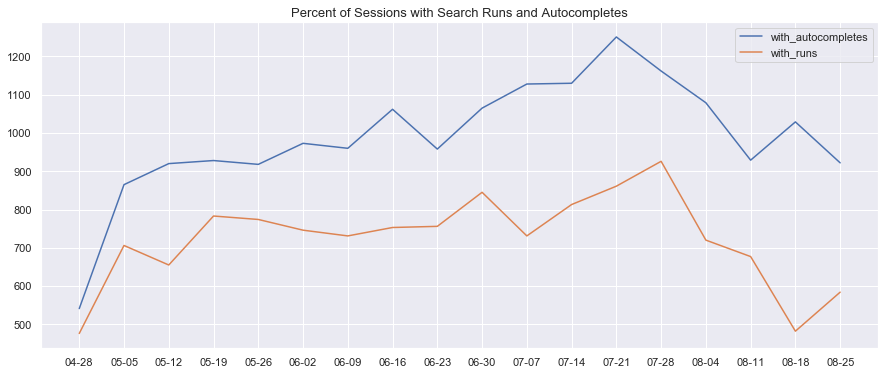

In [109]:
sql = '''
SELECT a.week, a.autocompletes_count, b.runs_count, c.total_count
FROM (SELECT strftime('%m-%d', occurred_at, 'weekday 1', '-7 days') as week,
             COUNT(*) AS autocompletes_count
      FROM events
      GROUP BY week, event_name
      HAVING event_name = 'search_autocomplete') AS a
LEFT JOIN (
SELECT strftime('%m-%d', occurred_at, 'weekday 1', '-7 days') as week,
       COUNT(*) AS runs_count
FROM events
GROUP BY week, event_name
HAVING event_name = 'search_run') AS b
ON a.week = b.week
LEFT JOIN (SELECT strftime('%m-%d', occurred_at, 'weekday 1', '-7 days') as week,
                  COUNT(*) AS total_count
            FROM events
            GROUP BY week) AS c
ON c.week = a.week

'''
SQL = pysqldf(sql)

sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 6));
plt.plot(SQL['week'], SQL['autocompletes_count'], label = 'with_autocompletes');
plt.plot(SQL['week'], SQL['runs_count'], label = 'with_runs');
plt.legend();
plt.title('Percent of Sessions with Search Runs and Autocompletes', fontsize = 13);

#### 2.1.2 Number of Searches
Next, let's take a look at the search times in each session. I do this base on the assumption that each user only use the search function one time per day (that is, they can conduct searches multiple times within a very short period of time in a day, but once they find out their result (or not), they quit searching and only do this once a day, so that is per session). 

So I calculate the number of searches on each search behavoris. It appears that autocomplete is typically used once or twice per session. But for full searches, it usually takes two or more times to get the search results, that makes full search less efficient than autocomplete search. Even though full searches are used less often than autocomplete search, it is still nesccessary to improve the search results given by full searches.

Though we generally use autocomplete search more, we still need to improve the full search resutls, thus saves users time and improve product experiences.

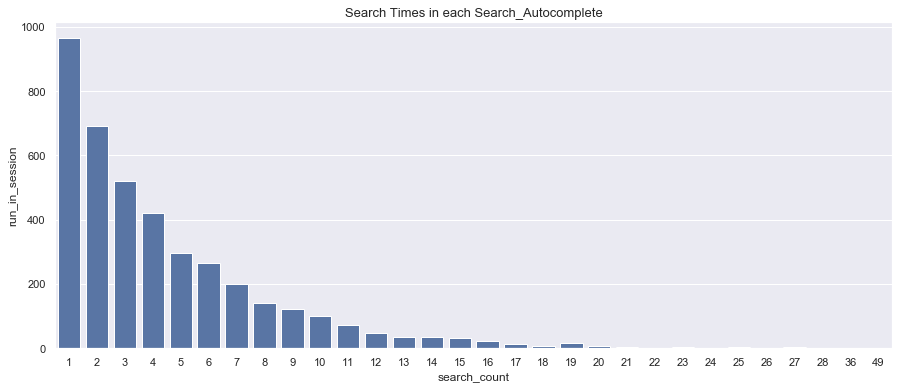

In [72]:
# For autocomplete search
sql = '''
SELECT search_count,
       COUNT(*) AS run_in_session
FROM (SELECT user_id,
             strftime('%Y-%m-%d', occurred_at) as date,
             COUNT(*) AS search_count
      FROM (SELECT *
            FROM events
            WHERE event_name = 'search_autocomplete')
      GROUP BY user_id)
GROUP BY search_count

'''
SQL = pysqldf(sql)

fig = plt.figure(figsize = (15, 6));
sns.barplot(x = 'search_count', y = 'run_in_session', data = SQL, color = 'b')
plt.title('Search Times in each Search_Autocomplete', fontsize = 13);

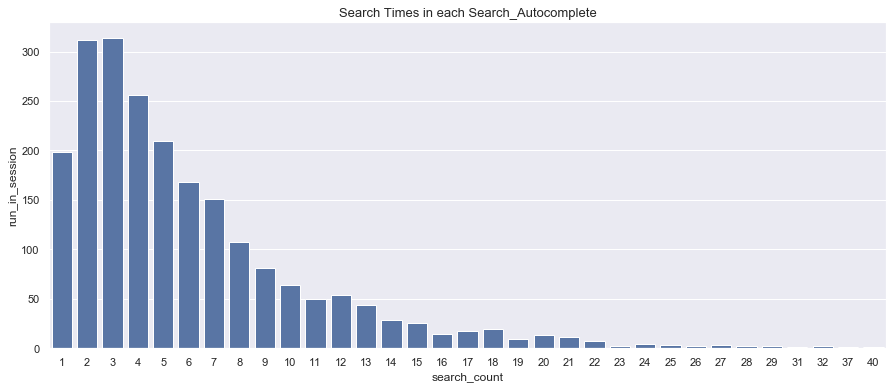

In [98]:
# For full search
sql = '''
SELECT search_count,
       COUNT(*) AS run_in_session
FROM (SELECT user_id,
             strftime('%Y-%m-%d', occurred_at) as date,
             COUNT(*) AS search_count
      FROM (SELECT *
            FROM events
            WHERE event_name = 'search_run')
      GROUP BY user_id)
GROUP BY search_count

'''
SQL = pysqldf(sql)

fig = plt.figure(figsize = (15, 6));
sns.barplot(x = 'search_count', y = 'run_in_session', data = SQL, color = 'b')
plt.title('Search Times in each Search_Autocomplete', fontsize = 13);

#### 2.1.3  Search Results Clicks
Once I find out there exists difference between two search behaviours, I should dig in deeper and see whether the difference stem from search results. By observing users' clicks after they search, I can see that whether they're actually getting their search answers.

It's clear that search isn't performing particularly well since almost no one finds their results after one search. In sessions during which users do search, they almost never click any of the results. This situation is perticularly severe for autocomplete search, indicating that users almost never get what they want through searching!

In [103]:
# For full search
sql = '''
WITH one AS(
SELECT user_id, event_name, occurred_at,
       CASE WHEN event_name = 'search_run' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) NOT LIKE 'search_click_result_%' THEN 0 
            WHEN event_name = 'search_run' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 2) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 3) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 4) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 5) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 'Over 5'
            WHEN event_name = 'search_run' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 2) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 3) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 4) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 4
            WHEN event_name = 'search_run' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 2) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 3) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 3
            WHEN event_name = 'search_run' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 2) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 2
            WHEN event_name = 'search_run' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 1
            END AS search_click               
FROM events
WHERE event_name IN ('search_run', 'search_click_result_1', 'search_click_result_2',
                     'search_click_result_3', 'search_click_result_4', 'search_click_result_5',
                     'search_click_result_6', 'search_click_result_7', 'search_click_result_8',
                     'search_click_result_9', 'search_click_result_10')
)
SELECT search_click,
       COUNT(*) AS count
FROM one
GROUP BY search_click
HAVING search_click IS NOT NULL
'''
SQL = pysqldf(sql)
SQL

,search_click,count
0,0,7883
1,1,2155
2,2,591
3,3,271
4,4,170
5,Over 5,601


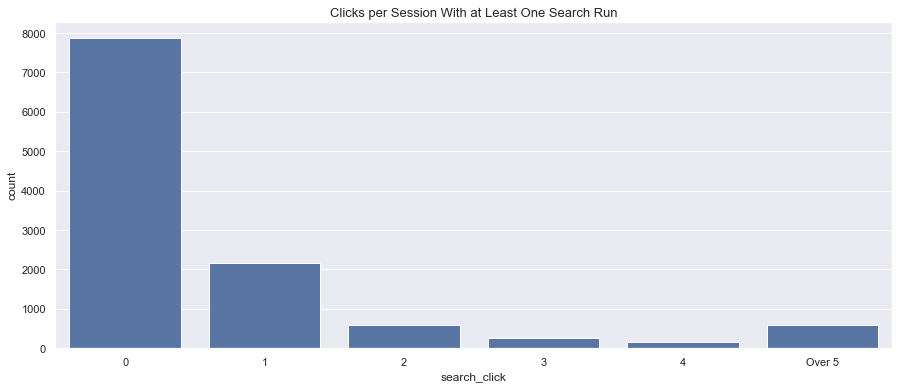

In [105]:
fig = plt.figure(figsize = (15, 6));
sns.barplot(x = 'search_click', y = 'count', data = SQL, color = 'b')
plt.title('Clicks per Session With at Least One Search Run', fontsize = 13);

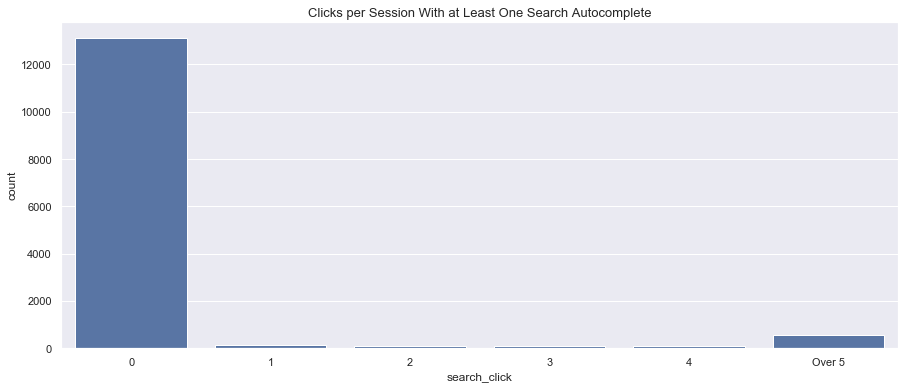

In [111]:
# For autocomplete search
sql = '''
WITH one AS(
SELECT user_id, event_name, occurred_at,
       CASE WHEN event_name = 'search_autocomplete' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) NOT LIKE 'search_click_result_%' THEN 0 
            WHEN event_name = 'search_autocomplete' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 2) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 3) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 4) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 5) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 'Over 5'
            WHEN event_name = 'search_autocomplete' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 2) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 3) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 4) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 4
            WHEN event_name = 'search_autocomplete' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 2) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 3) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 3
            WHEN event_name = 'search_autocomplete' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' AND
                 LEAD(event_name, 2) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 2
            WHEN event_name = 'search_autocomplete' AND 
                 LEAD(event_name, 1) OVER (PARTITION BY user_id ORDER BY occurred_at) LIKE 'search_click_result_%' THEN 1
            END AS search_click               
FROM events
WHERE event_name IN ('search_autocomplete', 'search_click_result_1', 'search_click_result_2',
                     'search_click_result_3', 'search_click_result_4', 'search_click_result_5',
                     'search_click_result_6', 'search_click_result_7', 'search_click_result_8',
                     'search_click_result_9', 'search_click_result_10')
)
SELECT search_click,
       COUNT(*) AS count
FROM one
GROUP BY search_click
HAVING search_click IS NOT NULL
'''
SQL = pysqldf(sql)

fig = plt.figure(figsize = (15, 6));
sns.barplot(x = 'search_click', y = 'count', data = SQL, color = 'b')
plt.title('Clicks per Session With at Least One Search Autocomplete', fontsize = 13);

#### 2.1.4 Search Results Recommendation
Since I find out users barely do any click after searching, there might be issues in the search results recommended by the system that users are not able to locate their desire needs. Thus, I count the numbers of clicks of 10 search results and see if each results being clicked are evenly distributed. 

I find out that users do have some preferences of certain kinds of search results, indicating that the original search results ordering is not very good. Click_result_2 has more clicks than the others, thus it's better to reverse the order of click results according to users' clicking preferences, so that the click results with more user counts should be display on top of the one that uses less often.

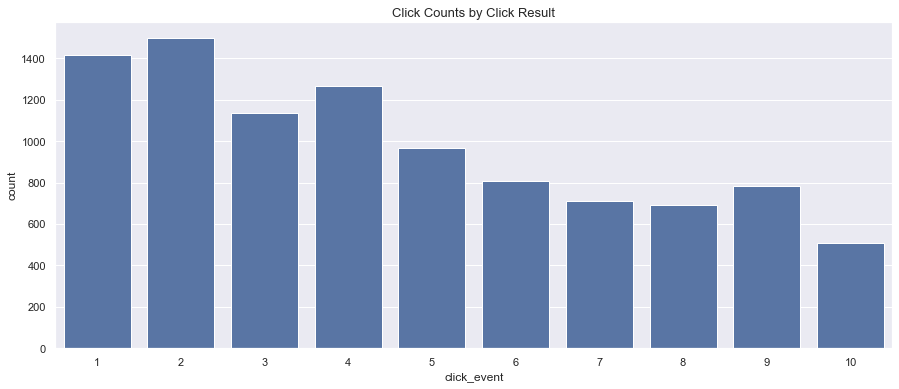

In [34]:
sql = '''
SELECT CASE WHEN event_name = 'search_click_result_1' THEN 1 
            WHEN event_name = 'search_click_result_2' THEN 2 
            WHEN event_name = 'search_click_result_3' THEN 3 
            WHEN event_name = 'search_click_result_4' THEN 4 
            WHEN event_name = 'search_click_result_5' THEN 5 
            WHEN event_name = 'search_click_result_6' THEN 6 
            WHEN event_name = 'search_click_result_7' THEN 7
            WHEN event_name = 'search_click_result_8' THEN 8 
            WHEN event_name = 'search_click_result_9' THEN 9 
            WHEN event_name = 'search_click_result_10' THEN 10 END AS click_event,
       COUNT(*) AS count
FROM events
GROUP BY event_name
HAVING event_name IN ('search_click_result_1', 'search_click_result_2',
                      'search_click_result_3', 'search_click_result_4',
                      'search_click_result_5', 'search_click_result_6',
                      'search_click_result_7', 'search_click_result_8',
                      'search_click_result_9', 'search_click_result_10')
ORDER BY event_name
'''
SQL = pysqldf(sql)

fig = plt.figure(figsize = (15, 6));
sns.barplot(x = 'click_event', y = 'count', data = SQL, color = 'b')
plt.title('Click Counts by Click Result', fontsize = 13);

#### 2.1.5 Search Function Retention
Finally, I conduct analysis to see if users keep using the search function. Users who run full searches rarely do so again within the following month, but those who use the autocomplete feature continue to use it at a higher rate.

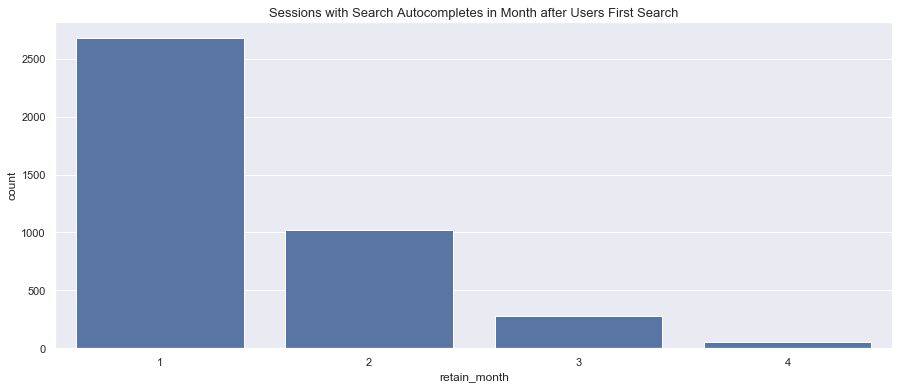

In [67]:
# For autocomplete
sql = '''
WITH one AS(
SELECT CAST(strftime('%m', occurred_at) AS INT)  AS month,
       user_id,
       event_name
FROM events
WHERE event_name = 'search_autocomplete'
GROUP BY user_id, month
)
SELECT retain_month,
       COUNT(retain_month) AS count
FROM (SELECT COUNT(user_id) AS retain_month
      FROM one
      GROUP BY user_id)
GROUP BY retain_month

'''
SQL = pysqldf(sql)

fig = plt.figure(figsize = (15, 6));
sns.barplot(x = 'retain_month', y = 'count', data = SQL, color = 'b')
plt.title('Sessions with Search Autocompletes in Month after Users First Search', fontsize = 13);

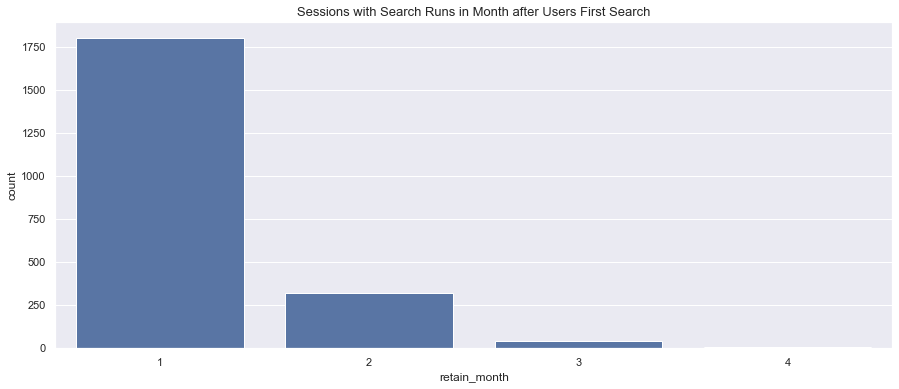

In [69]:
# For full search
sql = '''
WITH one AS(
SELECT CAST(strftime('%m', occurred_at) AS INT)  AS month,
       user_id,
       event_name
FROM events
WHERE event_name = 'search_run'
GROUP BY user_id, month
)
SELECT retain_month,
       COUNT(retain_month) AS count
FROM (SELECT COUNT(user_id) AS retain_month
      FROM one
      GROUP BY user_id)
GROUP BY retain_month

'''
SQL = pysqldf(sql)

fig = plt.figure(figsize = (15, 6));
sns.barplot(x = 'retain_month', y = 'count', data = SQL, color = 'b')
plt.title('Sessions with Search Runs in Month after Users First Search', fontsize = 13);

## 3 Conclusion
From all the comparisons, the autocomplete search performs way more better than full search due to its conviniency. However, it is still not getting much clicks after users conduct the autocomplete search. Moreover, people are more likely do the autocomplete at the very beginning and if they're not able to find what they're looking for, they will then switch to the full search. Therefore, reorganizing the search results order is one of the most important things to be consider. 
